Jun Pan 07/11//2019

INTRODUCE OF PROJECT

DATABASE

MovieLens is a web-based recommender system and virtual community that recommends movies for its users to watch, based on their film preferences using collaborative filtering of members' movie ratings and movie reviews. It contains about 11 million ratings for about 10000 movies.[1] MovieLens was created in 1997 by GroupLens Research, a research lab in the Department of Computer Science and Engineering at the University of Minnesota in order to gather research data on personalized recommendations. In this study, we are going to use a 100k database originally from movieLens, which inclusing movies, ratings, links and tags four files.  In this dataset, we have 100,004 ratings which were rated by 671 users on 9066 movies.

The posters of movies can get it from www.themoviedb.org.  We need get api key in advance in order to fetch the posters. 

ALTERNATING LEAST SQUARES ALGORITHM
Collaborative filtering is commonly used for recommender systems. These techniques aim to fill in the missing entries of a user-item association matrix. 'spark.mllib' currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. 'spark.mllib' uses the alternating least squares (ALS) algorithm to learn these latent factors [2]. When using collaborative filtering, getting recommendations is not as simple as predicting for the new entries using a previously generated model. Instead, we need to train again the model but including the new user preferences in order to compare them with other users in the dataset. That is, the recommender needs to be trained every time we have new user ratings (although a single model can be used by multiple users). This makes the process expensive, and it is one of the reasons why scalability is a problem (and Spark a solution!). 

SPARK
Spark is a platform for cluster computing. Spark lets you spread data and computations over clusters with multiple nodes (think of each node as a separate computer). Splitting up your data makes it easier to work with very large datasets because each node only works with a small amount of data.

As each node works on its own subset of the total data, it also carries out a part of the total calculations required, so that both data processing and computation are performed in parallel over the nodes in the cluster. It is a fact that parallel computation can make certain types of programming tasks much faster [3].

Spark will be used locally in our study.

In [1]:
#Set Working Environment
import pyspark as ps
from pyspark.ml.tuning import CrossValidator
from pyspark.sql import functions as F
from pyspark.sql import DataFrameNaFunctions as DFna
from pyspark.sql.functions import udf, col, when
from pyspark.sql.functions import col
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.tuning import ParamGridBuilder

import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import os, sys, requests, json



spark = ps.sql.SparkSession.builder \
            .master("local[4]") \
            .appName("building recommender") \
            .getOrCreate() # create a spark session
            
sc = spark.sparkContext # create a spark context

In [2]:
# read movies CSV using spark 
#reference: https://stackoverflow.com/questions/28782940/load-csv-file-with-spark
movies_df = spark.read.csv('C:/Users/tbao/Desktop/data612 final project/movies/movies.csv',
                         header=True, quote='"', sep=",", inferSchema=True) 
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [3]:
#View Schema
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
# read ratings CSV
ratings_df = spark.read.csv('C:/Users/tbao/Desktop/data612 final project/movies/ratings.csv',
                         header=True, quote='"', sep=",", inferSchema=True)
ratings_df.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [5]:
# Filter to show only "userId" less than 100
ratings_df.filter(col("userId") < 100).show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
|     1|   1263|   2.0|1260759151|
|     1|   1287|   2.0|1260759187|
|     1|   1293|   2.0|1260759148|
|     1|   1339|   3.5|1260759125|
|     1|   1343|   2.0|1260759131|
|     1|   1371|   2.5|1260759135|
|     1|   1405|   1.0|1260759203|
|     1|   1953|   4.0|1260759191|
|     1|   2105|   4.0|1260759139|
|     1|   2150|   3.0|1260759194|
|     1|   2193|   2.0|1260759198|
|     1|   2294|   2.0|1260759108|
|     1|   2455|   2.5|1260759113|
|     1|   2968|   1.0|1260759200|
|     1|   3671|   3.0|1260759117|
+------+-------+------+----------+
only showing top 20 rows



In [6]:
# Count the number of distinct userIds and distinct movieIds
total_count = ratings_df.count()
num_users = ratings_df.select("userId").distinct().count()
num_movies = ratings_df.select("movieId").distinct().count()
print(total_count)
print(num_users)
print(num_movies)

100004
671
9066


So total ratings in this dataset are 100,004; total number of unique users are 671; total unique movies in the dataset are 9066

In [7]:
# Group data by userId, count movies (total numbers of movies rated by each user)
ratings_df.groupBy("userId").count().show()

+------+-----+
|userId|count|
+------+-----+
|   148|  132|
|   463|  483|
|   471|  216|
|   496|  126|
|   243|  307|
|   392|   25|
|   540|   20|
|   623|  103|
|    31|   69|
|   516|  149|
|    85|  107|
|   137|   80|
|   251|  119|
|   451|   52|
|   580|  922|
|    65|   27|
|   458|   76|
|    53|   46|
|   255|  145|
|   481|  436|
+------+-----+
only showing top 20 rows



In [8]:
movies_counts = ratings_df.groupBy(col("movieId")).agg(F.count(col("rating")).alias("counts"))
movies_counts.show()

+-------+------+
|movieId|counts|
+-------+------+
|   1580|   190|
|   2659|     3|
|   3794|     5|
|   3175|    65|
|    471|    49|
|   1088|    53|
|   1342|    17|
|   1645|    60|
|   2366|    23|
|   6620|    17|
|   8638|    17|
|  96488|     4|
| 160563|     2|
|   7982|     3|
|   1238|    17|
|   1959|    30|
|    463|     7|
|   2122|    11|
|   1591|    15|
|   5518|     1|
+-------+------+
only showing top 20 rows



In [9]:
#View Schema
ratings_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [10]:
# read links CSV
links_df = spark.read.csv('C:/Users/tbao/Desktop/data612 final project/movies/links.csv',
                         header=True, quote='"', sep=",", inferSchema=True)
links_df.show()

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
|     11|112346|  9087|
|     12|112896| 12110|
|     13|112453| 21032|
|     14|113987| 10858|
|     15|112760|  1408|
|     16|112641|   524|
|     17|114388|  4584|
|     18|113101|     5|
|     19|112281|  9273|
|     20|113845| 11517|
+-------+------+------+
only showing top 20 rows



In [11]:
#View Schema
links_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: integer (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [12]:
# read links CSV
tags_df = spark.read.csv('C:/Users/tbao/Desktop/data612 final project/movies/tags.csv',
                         header=True, quote='"', sep=",", inferSchema=True)
tags_df.show()

+------+-------+--------------------+----------+
|userId|movieId|                 tag| timestamp|
+------+-------+--------------------+----------+
|    15|    339|sandra 'boring' b...|1138537770|
|    15|   1955|             dentist|1193435061|
|    15|   7478|            Cambodia|1170560997|
|    15|  32892|             Russian|1170626366|
|    15|  34162|         forgettable|1141391765|
|    15|  35957|               short|1141391873|
|    15|  37729|          dull story|1141391806|
|    15|  45950|          powerpoint|1169616291|
|    15| 100365|            activist|1425876220|
|    15| 100365|         documentary|1425876220|
|    15| 100365|              uganda|1425876220|
|    23|    150|          Ron Howard|1148672905|
|    68|   2174|               music|1249808064|
|    68|   2174|               weird|1249808102|
|    68|   8623|        Steve Martin|1249808497|
|    73| 107999|              action|1430799184|
|    73| 107999|               anime|1430799184|
|    73| 107999|    

In [13]:
#View Schema
tags_df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: integer (nullable = true)



After review all the dataset, we are going to build ALS model to train the data.  
Firstly, we are going to get and parse movies and ratings data into Spark RDDs. Resilient Distributed Datasets (RDD) is a fundamental data structure of Spark. It is an immutable distributed collection of objects. Each dataset in RDD is divided into logical partitions, which may be computed on different nodes of the cluster. RDDs can contain any type of Python, Java, or Scala objects, including user-defined classes [4]. 

In [14]:
#datafram before 
ratings = ratings_df.rdd
numRatings = ratings.count()
numUsers = ratings.map(lambda r: r[0]).distinct().count()
numMovies = ratings.map(lambda r: r[1]).distinct().count()

print(numRatings, numUsers, numMovies)

100004 671 9066


In [15]:
#Split dataset train (60%), validation (20%), test (20%)
training_df, validation_df, test_df = ratings_df.randomSplit([.6, .2, .2], seed=123)

In [16]:
training_df

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

Secondly, we are going to build an ALS based recommender system. ALS recommender is a matrix factorization algorithm that uses Alternating Least Squares with Weighted-Lamda-Regularization (ALS-WR). It makes the regularization parameter less dependent on the scale of the dataset. This way the best parameter learned from the sampled subset can be aplied to the full dataset and we will get similar performance. The latent factors should explain the observed user to item ratings and map new users to optimal movie recommendations. Accuracy of ALS recommendation system will be checked by using RMSE.
We set the following parameters for alternating least squares model. We overiew the ranks and pick the best model. RMSE are used for error checking.

In [17]:
seed = 123
iterations = 10
regularization_parameter = 0.1
ranks = range(4, 12)
errors = []
err = 0
tolerance = 0.02

In [18]:
min_error = float('inf')
best_rank = -1
best_iteration = -1

for rank in ranks:
    als = ALS(maxIter=iterations, regParam=regularization_parameter, rank=rank, userCol="userId", itemCol="movieId", ratingCol="rating")
    model = als.fit(training_df)
    predictions = model.transform(validation_df)
    new_predictions = predictions.filter(col('prediction') != np.nan)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(new_predictions)
    errors.append(rmse)

    print(rank, rmse)
    if rmse < min_error:
        min_error = rmse
        best_rank = rank
print(best_rank)

4 0.9338392118912122
5 0.9288530101854114
6 0.9395727152626402
7 0.9355229914153406
8 0.944128278794981
9 0.9403311102506741
10 0.941391022801686
11 0.9423956026252883
5


It shows that rank 4 is the best, then we choose it as final model and check the RMSE value

In [19]:
final_als = ALS(maxIter=10, 
                regParam=0.1, 
                rank=4, 
                userCol="userId", 
                itemCol="movieId", 
                ratingCol="rating")
final_model = final_als.fit(training_df)
final_pred = final_model.transform(validation_df)
final_pred = final_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(final_pred)
print(rmse)

0.9338392118912122


Let's take random users by user_ids who have already rated some movies. Then, we get all of their ratings and sort to show the top 10 rated movies.

In [20]:
import random

np.random.seed(42)
user_id = np.random.choice(numUsers)

In [21]:
#Showing 10 movie ratings of a random selected user
new_user_ratings = ratings_df.filter(ratings_df.userId == user_id)
new_user_ratings.sort('rating', ascending=True).take(10) 

[Row(userId=102, movieId=2240, rating=1.0, timestamp=957894741),
 Row(userId=102, movieId=1888, rating=1.0, timestamp=957895013),
 Row(userId=102, movieId=37, rating=1.0, timestamp=959976593),
 Row(userId=102, movieId=3354, rating=1.0, timestamp=957893451),
 Row(userId=102, movieId=3484, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=3511, rating=1.0, timestamp=957893428),
 Row(userId=102, movieId=2541, rating=1.0, timestamp=957894760),
 Row(userId=102, movieId=2548, rating=1.0, timestamp=957980378),
 Row(userId=102, movieId=1584, rating=2.0, timestamp=957894285),
 Row(userId=102, movieId=590, rating=2.0, timestamp=957894532)]

In [22]:
#Statistical analysis 
new_user_ratings.describe('rating').show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|               678|
|   mean|3.9749262536873156|
| stddev|0.8529848074277973|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



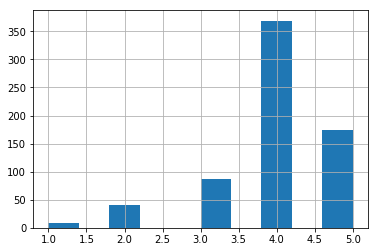

In [23]:
new_user_ratings.toPandas()['rating'].hist()
plt.show()

Predict Unrated Movies
Get a list of movieIds with more than 25 users given rating

In [24]:
new_user_rated_movieIds = [i.movieId for i in new_user_ratings.select('movieId').distinct().collect()]
movieIds = [i.movieId for i in movies_counts.filter(movies_counts.counts > 25).select('movieId').distinct().collect()]
new_user_unrated_movieIds = list(set(movieIds) - set(new_user_rated_movieIds))

Lets now take all the unrated movie id's for this user and create a spark dataframe with 0 for the predicted rating.

In [25]:
import time
import sqlite3
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

num_ratings = len(new_user_unrated_movieIds)
cols = ('userId', 'movieId', 'timestamp')
timestamps = [int(time.time())] * num_ratings
userIds = [user_id] * num_ratings
# ratings = [0] * num_ratings
new_user_preds = sqlContext.createDataFrame(zip(userIds, new_user_unrated_movieIds, timestamps), cols)

In [27]:
new_user_preds = final_model.transform(new_user_preds).filter(col('prediction') != np.nan)

In [28]:
new_user_preds.sort('prediction', ascending=False).take(10)

[Row(userId=102, movieId=951, timestamp=1563231968, prediction=4.814425468444824),
 Row(userId=102, movieId=39183, timestamp=1563231968, prediction=4.677949905395508),
 Row(userId=102, movieId=306, timestamp=1563231968, prediction=4.669471740722656),
 Row(userId=102, movieId=6016, timestamp=1563231968, prediction=4.65004825592041),
 Row(userId=102, movieId=5225, timestamp=1563231968, prediction=4.648679256439209),
 Row(userId=102, movieId=1223, timestamp=1563231968, prediction=4.644265651702881),
 Row(userId=102, movieId=3000, timestamp=1563231968, prediction=4.627032279968262),
 Row(userId=102, movieId=1060, timestamp=1563231968, prediction=4.601822853088379),
 Row(userId=102, movieId=44555, timestamp=1563231968, prediction=4.599433898925781),
 Row(userId=102, movieId=475, timestamp=1563231968, prediction=4.5262274742126465)]

We can search for movie posters by id in the movie database and then grab links to the image files from www.themoviedb.org. The API key are stored in environment vairable.

In [83]:
# Get base url filepath structure. w185 corresponds to size of movie poster.
#reference: https://www.johannesbader.ch/2013/11/tutorial-download-posters-with-the-movie-database-api-in-python/
 
api_key = '47c76540878f2d2afab2fde73129832b'

headers = {'Accept': 'application/json'}
payload = {'api_key': api_key} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(tmdb_id, base_url):
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(tmdb_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': api_key} 
    response = requests.get(movie_url, params=payload, headers=headers)
    file_path = json.loads(response.text)['posters'][0]['file_path']
    return base_url + file_path

In [84]:
from IPython.display import Image
from IPython.display import display

Now that we have a pipeline to go directly from the TheMovieDB id to the url to displaying the movie poster. With this machinery in hand lets first get the top rated movies the user has already rated:

In [93]:
new_user_ratings = new_user_ratings.sort('rating', ascending=False).join(links_df, new_user_ratings.movieId == links_df.movieId)

In [95]:
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url)) for movie in new_user_ratings.take(10))

In [96]:
display(*posters)

Cool, now let's see what top recommendations are for this user.

In [100]:
new_user_preds = new_user_preds.sort('prediction', ascending=False).join(links_df, new_user_preds.movieId == links_df.movieId)

In [102]:
posters = tuple(Image(url=get_poster(movie.tmdbId, base_url)) for movie in new_user_preds.take(10))

In [103]:
display(*posters)

References:

1.http://license.umn.edu/technologies/z05173_movielens-database


2.https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html


3.https://www.tutorialspoint.com/apache_spark/


4.https://www.tutorialspoint.com/apache_spark/apache_spark_rdd.html